In [150]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [20]:
GOOD_REVIEW_THRESHOLD = 7

In [21]:
VAL_FRACTION = 0.25

## GET DATA

In [2]:
hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
# Parsing the XML file
xmlparse = Xet.fromstring(hot)

hot_array = []
for item in xmlparse:
    dict_element = {
        "id": item.get("id"),
        "rank": item.get("rank")
    }
    for option in item:
        dict_element[option.tag] = option.get("value")
    hot_array.append(dict_element)

In [3]:
hot_array[:2]

[{'id': '328866',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/N0hCcxXw8d7vUjKfsYO6vg__thumb/img/K4DDlRzl6qlQf9L_oMLb7g9WUYo=/fit-in/200x150/filters:strip_icc()/pic6121929.png',
  'name': "My Father's Work",
  'yearpublished': '2021'},
 {'id': '336794',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/1gQABuftAVgk1qshkMyDEw__thumb/img/Ovni6sWuvyfj9LWn-hnHzpCELF8=/fit-in/200x150/filters:strip_icc()/pic6125184.jpg',
  'name': 'Galaxy Trucker',
  'yearpublished': '2021'}]

In [4]:
max_comments_per_page = 1
hot_array_ids = [h['id'] for h in hot_array]
ids = ','.join(hot_array_ids)
page_size = 100
page_number = 0
comments_array = []

while max_comments_per_page > 0:
    page_number += 1
    print(f"page number = {page_number}", end=" ")
    comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

    # Parsing the XML file
    xmlparse = Xet.fromstring(comments)
    comments_per_item = []
    for item in xmlparse:        
        for option in item:
            if option.tag == 'comments':
                comments_per_page = 0
                for comment in option:
                    comments_per_page += 1
                    dict_element = {
                        "id": item.get("id"),
                        "username": comment.get("username"),
                        "rating": comment.get("rating"),
                        "value": comment.get("value")
                    }
                    comments_array.append(dict_element)
                if comments_per_page==0:
                    hot_array_ids.pop(item.get("id"))
                    ids = ','.join(hot_array_ids)
                comments_per_item.append(comments_per_page)
    max_comments_per_page = max(comments_per_item)
    print(f"(max: {max(comments_per_item)}, len = {len(comments_per_item)})")

page number = 1 max = 100 len = 50

page number = 2 max = 100 len = 50

page number = 3 max = 100 len = 50

page number = 4 max = 100 len = 50

page number = 5 max = 100 len = 50

page number = 6 max = 100 len = 50

page number = 7 max = 100 len = 50

page number = 8 max = 100 len = 50

page number = 9 max = 100 len = 50

page number = 10 max = 100 len = 50

page number = 11 max = 100 len = 50

page number = 12 max = 100 len = 50

page number = 13 max = 100 len = 50

page number = 14 max = 100 len = 50

page number = 15 max = 100 len = 50

page number = 16 max = 100 len = 50

page number = 17 max = 100 len = 50

page number = 18 max = 100 len = 50

page number = 19 max = 100 len = 50

page number = 20 max = 100 len = 50

page number = 21 max = 100 len = 50

page number = 22 max = 100 len = 50

page number = 23 max = 100 len = 50

page number = 24 max = 100 len = 50

page number = 25 max = 100 len = 50

page number = 26 max = 100 len = 50

page number = 27 max = 100 len = 50

page numbe

In [6]:
comments_array[:2]

[{'id': '328866',
  'username': '4tsawicki',
  'rating': 'N/A',
  'value': 'Feb 2022'},
 {'id': '328866', 'username': 'alexbatbee', 'rating': 'N/A', 'value': 'KS'}]

In [7]:
comments_df = pd.DataFrame(comments_array)

In [8]:
comments_df

,id,username,rating,value
0,328866,4tsawicki,N/A,Feb 2022
1,328866,alexbatbee,N/A,KS
2,328866,Amekins,N/A,Backer # 1267 on Kickstarter 4/27/2021 Funded ...
3,328866,BlueFoxMoon,N/A,Pre-release - Kickstarter
4,328866,DadouXIII,N/A,February - 2022 Campaign still running
...,...,...,...,...
84778,167791,z_zadar,9,Some games are so much fun. Others can be a li...
84779,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
84780,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
84781,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


In [9]:
comments_df.to_csv("comments_20210428.csv", index=False)

In [151]:
# comments_df = pd.read_csv("comments_20210428.csv")

## SPLIT RATED AND NON-RATED COMMENTS

In [11]:
comments_df.rating.value_counts()

N/A        20157
10         13324
9          12900
8          11190
7           6464
           ...  
1.12           1
7.23333        1
7.0992         1
6.52           1
7.63           1
Name: rating, Length: 513, dtype: int64

In [12]:
rated_comments = comments_df.query('rating != "N/A"')

In [76]:
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)

In [14]:
rated_comments.shape

(64626, 4)

In [15]:
not_rated_comments.shape

(20157, 4)

In [16]:
# usare i commenti con rating per addestrare e testare modello

In [18]:
rated_comments = rated_comments.sample(frac=1)

In [22]:
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [23]:
train_examples[:4]

['Bought new from Miniature Market.  Really enjoyed this game.  Great presentation and artwork.  Felt a little like 7 Wonders Duel with the card drafting, which I enjoy.  Look forward to playing again and adding in the different family of cards that add more complexity to the game.',
 'Played this a few times, pretty solid strategy / area of control game with too little interaction for me.',
 'Want to play more to be able to judge',
 'Solo']

In [24]:
train_labels[:4]

[1, 1, 0, 1]

## COMPOSE MODEL

In [25]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 1.23638675e-01, -9.46443602e-02,  4.59179133e-02,
         6.32842124e-01, -2.27451414e-01, -1.80559322e-01,
        -1.51872560e-01, -2.69909780e-02, -2.04914123e-01,
         1.69491008e-01,  7.94355273e-02,  3.48725349e-01,
        -1.18448123e-01,  7.05779344e-02,  1.54962018e-01,
        -2.29443356e-01,  1.46048695e-01,  2.32657582e-01,
         1.35825932e-01, -3.89798164e-01, -1.85039148e-01,
        -3.28751475e-01,  1.37741268e-01,  1.45023596e-02,
        -2.07724959e-01,  1.11409456e-01, -5.06411672e-01,
         2.67550536e-02,  1.25106769e-02, -8.72540548e-02,
        -9.28421021e-02, -8.13109353e-02,  1.13952190e-01,
        -7.88327307e-02, -9.36294906e-03,  4.33735698e-01,
        -5.92677016e-03, -1.35490552e-01, -8.75878893e-03,
        -6.03785098e-01,  7.50158681e-03,  4.95278277e-02,
        -3.87958199e-01,  1.12729117e-01,  1.76059660e-02,
        -1.46653242e-02, -1.26522571e-01, -2.88571835e-01,
       

In [26]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

In [28]:
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

16156

## TRAINING MODEL 

In [29]:
x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

In [30]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=1
)

Train on 48470 samples, validate on 16156 samples
Epoch 1/40
48470/48470 [==============================] - 32s 651us/sample - loss: 0.5129 - accuracy: 0.8166 - val_loss: 0.4089 - val_accuracy: 0.8458
Epoch 2/40
48470/48470 [==============================] - 31s 631us/sample - loss: 0.3429 - accuracy: 0.8669 - val_loss: 0.3279 - val_accuracy: 0.8697
Epoch 3/40
48470/48470 [==============================] - 30s 624us/sample - loss: 0.2761 - accuracy: 0.8921 - val_loss: 0.3107 - val_accuracy: 0.8752
Epoch 4/40
48470/48470 [==============================] - 31s 637us/sample - loss: 0.2380 - accuracy: 0.9069 - val_loss: 0.3147 - val_accuracy: 0.8747
Epoch 5/40
48470/48470 [==============================] - 30s 624us/sample - loss: 0.2095 - accuracy: 0.9187 - val_loss: 0.3249 - val_accuracy: 0.8716
Epoch 6/40
48470/48470 [==============================] - 30s 624us/sample - loss: 0.1871 - accuracy: 0.9286 - val_loss: 0.3406 - val_accuracy: 0.8667
Epoch 7/40
48470/48470 [====================

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [33]:
epochs = range(1, len(acc) + 1) 

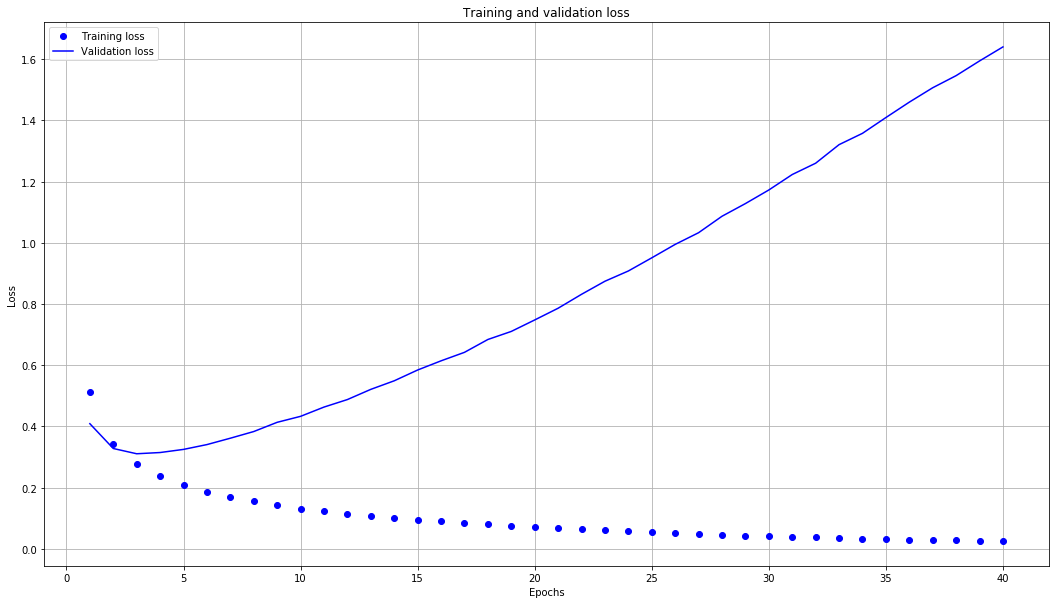

In [34]:
# "bo" is for "blue dot"
plt.figure(figsize=(18, 10))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

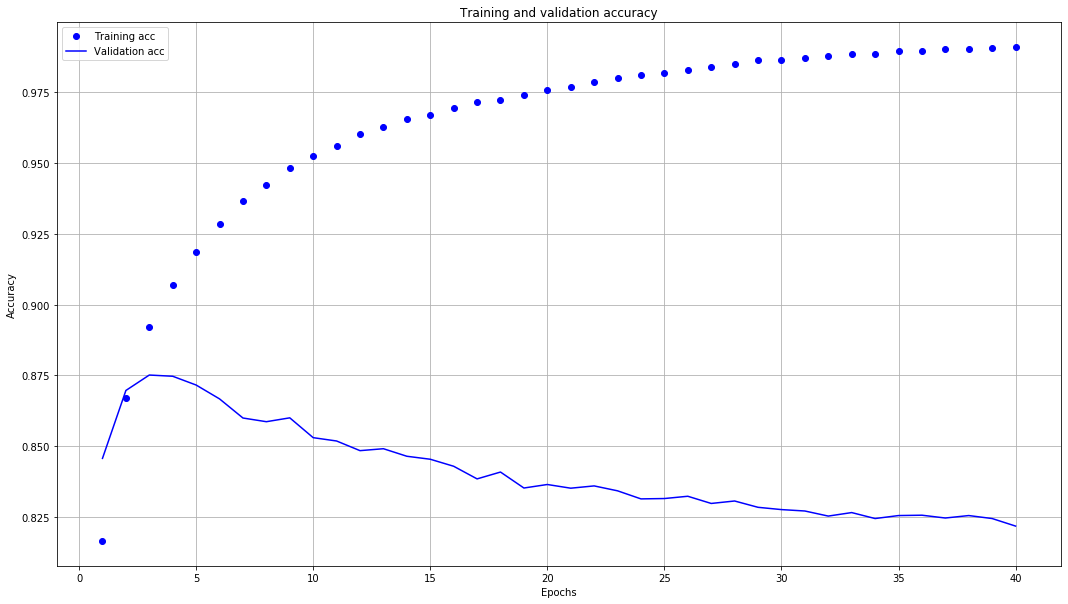

In [35]:
plt.figure(figsize=(18, 10))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [36]:
def print_my_examples(inputs, results, limit=None):
    result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [44]:
inputs = x_train[-10:]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results)

input:
"Played a friend's copy and immediately had to get one myself to add to my collection. Fantastic co-op game!"
score: 0.999998

input:
"missed Kickstarter twice..."
score: 0.989256

input:
"Tucatjáték. Bocsánat. De működik."
score: 1.000000

input:
"I love games like scythe and terraforming mars, but i also like variety. And though you can get that from a million expansions, right out of the box Gloomhaven has six super distinct classes to play, and like a hundred scenarios. Variety is it’s middle name. Every game I’ve played of the 20-30 games so far has been different, and thats all i really ever wanted."
score: 0.999934

input:
"I’ve tried it a couple of times now and my first impression is that this is the ultimate iteration of engine-building. It’s the distillation of the precise joy of turning one resource into two of another which can then be swapped for points and victory. The components are also gorgeous and thematic: unholy, violent artifacts yield death essence, plants

In [45]:
y_train[-10:]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1]

In [152]:
## APPLY MODEL ON NON-RATED COMMENTS

In [47]:
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

input:
"Feb 2022"
score: 1.000000

input:
"KS"
score: 0.999893

input:
"Backer # 1267 on Kickstarter 4/27/2021 Funded May 14 2021 Pledge level: New Generation $99 Anticipated delivery date Feburary 2022"
score: 1.000000

input:
"Pre-release - Kickstarter"
score: 0.598800

input:
"February - 2022 Campaign still running"
score: 1.000000

input:
"Preordered with Sentry Box for Feb 2022 delivery (90USD/120CAD owing)"
score: 1.000000

input:
"I was hyped for this but playthroughs revealed that it is more so an Ameritrash style game (I hate the terms but use them colloquially at least) fastened onto rather basic resource gathering, worker placement mechanisms with shifting goals and mini-objectives. Very exciting on paper, and a I do like the implementation of 'maladjustments' but wanted a richer euro-style tapestry and/or engine to run the game.  The app, flipbook town and scenarios are painted as innovative and exciting concepts but to the contrary, without them, you would be left with a v

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [153]:
rated_comments.head()

,id,username,rating,value
35321,163968,Scottyglc,7.5,Bought new from Miniature Market. Really enjo...
77200,169786,philsurette,7.0,"Played this a few times, pretty solid strategy..."
58535,244521,tobytoast,6.0,Want to play more to be able to judge
24722,256960,origamifan,10.0,Solo
52479,162886,mbascom,9.0,Fun challenge and puzzle. Only negative is tha...


In [63]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
rated_comments_grouped.head()

,id,rating_mean,rating_count
0,111105,6.881935,403
1,162886,8.350475,3465
2,163068,7.766059,938
3,163968,7.181820,1167
4,167355,8.418033,1768


In [77]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [81]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
not_rated_comments_grouped.head()

,id,rating_mean,rating_count
0,111105,7.450000,184
1,162886,8.616243,1022
2,163068,8.664252,428
3,163968,8.247442,430
4,167355,8.541124,676


In [123]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'))
grouped = grouped.merge(pd.DataFrame(hot_array), on='id')
grouped['rank'] = grouped['rank'].astype(int)

In [124]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished
0,111105,6.881935,403,7.450000,184,45,https://cf.geekdo-images.com/KSrotdESv2kphKZGb...,Agents of SMERSH,2012
1,162886,8.350475,3465,8.616243,1022,18,https://cf.geekdo-images.com/a13ieMPP2s0KEaKNY...,Spirit Island,2017
2,163068,7.766059,938,8.664252,428,29,https://cf.geekdo-images.com/9gob752VqEklQFV_g...,Trickerion: Legends of Illusion,2015
3,163968,7.181820,1167,8.247442,430,36,https://cf.geekdo-images.com/hNyO7u1pR3oSxKTEL...,Elysium,2015
4,167355,8.418033,1768,8.541124,676,32,https://cf.geekdo-images.com/tAqLpWxQ0Oo3GaPP3...,Nemesis,2018


In [125]:
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) / (grouped['rating_count_review']+grouped['rating_count_comments'])

In [126]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,fixed_rating
0,111105,6.881935,403,7.450000,184,45,https://cf.geekdo-images.com/KSrotdESv2kphKZGb...,Agents of SMERSH,2012,7.060000
1,162886,8.350475,3465,8.616243,1022,18,https://cf.geekdo-images.com/a13ieMPP2s0KEaKNY...,Spirit Island,2017,8.411009
2,163068,7.766059,938,8.664252,428,29,https://cf.geekdo-images.com/9gob752VqEklQFV_g...,Trickerion: Legends of Illusion,2015,8.047484
3,163968,7.181820,1167,8.247442,430,36,https://cf.geekdo-images.com/hNyO7u1pR3oSxKTEL...,Elysium,2015,7.468744
4,167355,8.418033,1768,8.541124,676,32,https://cf.geekdo-images.com/tAqLpWxQ0Oo3GaPP3...,Nemesis,2018,8.452079


In [127]:
grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [146]:
def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<center><img src="'+ path + '" style=max-height:124px;"/></center>'

In [147]:
# TOP 5 RANK
HTML(grouped.sort_values('rank').head(5).to_html(escape=False, formatters={'thumbnail': path_to_image_html}))

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
42,,My Father's Work,5.500000,8.923077,8.466667,1,2021
30,,Oath: Chronicles of Empire and Exile,8.031238,8.800392,8.576056,3,2021
35,,Lost Ruins of Arnak,7.955494,8.440650,8.097406,4,2020
37,,Dune: Imperium,8.122007,8.456682,8.209506,5,2020
44,,Brew,6.250000,8.875000,8.000000,6,2021


In [148]:
# TOP 5 REVIEW RANK
HTML(grouped.sort_values('rating_mean_review', ascending=False).head(5).to_html(escape=False, formatters={'thumbnail': path_to_image_html}))

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
38,,Stationfall,9.428571,9.100000,9.291667,41,2021
32,,Kemet: Blood and Sand,8.988235,8.763388,8.782500,39,2021
18,,Eclipse: Second Dawn for the Galaxy,8.734295,8.834632,8.769735,42,2020
14,,Brass: Birmingham,8.689090,8.582346,8.658587,26,2018
29,,Gloomhaven: Jaws of the Lion,8.622822,8.692255,8.641885,20,2020


In [149]:
# TOP 5 FIXED RANK
HTML(grouped.sort_values('fixed_rating', ascending=False).head(5).to_html(escape=False, formatters={'thumbnail': path_to_image_html}))

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
38,,Stationfall,9.428571,9.100000,9.291667,41,2021
32,,Kemet: Blood and Sand,8.988235,8.763388,8.782500,39,2021
18,,Eclipse: Second Dawn for the Galaxy,8.734295,8.834632,8.769735,42,2020
41,,Hidden Leaders,8.192308,9.247826,8.687755,13,2022
28,,Zombicide (2nd Edition),7.608696,9.098305,8.680488,46,2021
